<a href="https://colab.research.google.com/github/tiara070403/skripsi/blob/main/skripsilagi_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikit-learn pandas matplotlib seaborn Sastrawi transformers wordcloud nltk
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('/content/crawling.csv', index_col=0)

In [5]:
df_copy = df.copy()

In [6]:
df = df[['created_at', 'full_text']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5349 entries, 1858070162362204643 to 1230765438897815552
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5349 non-null   object
 1   full_text   5349 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


In [8]:
# Mengubah teks menjadi lowercase
df['full_text'] = df['full_text'].astype(str).str.lower()
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])

In [9]:
# Menghapus duplikat
initial_duplicates = df.duplicated().sum()
df = df.drop_duplicates(subset=['full_text'])
print(f"Jumlah duplikat awal: {initial_duplicates}")
print(f"Jumlah duplikat setelah drop: {df.duplicated().sum()}")

Jumlah duplikat awal: 4
Jumlah duplikat setelah drop: 0


In [10]:
# Menghapus baris dengan nilai null (setelah dropna subset)
df = df.dropna()
print(f"Jumlah nilai null setelah dropna: \n{df.isnull().sum()}")

Jumlah nilai null setelah dropna: 
created_at    0
full_text     0
dtype: int64


In [11]:
# Case Folding
df['full_text'] = df['full_text'].str.lower()
print("\nDataFrame setelah Case Folding:")
print(df.head())


DataFrame setelah Case Folding:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi 'genjot...  
1467691301155979267  @leonita_lestari ada perkoempoelan pentjinta a...  
1836014724523458593  [press release sowan ukm ke ukm unit pandu lin...  
1835164951125917967  [press release sowan ukm ke ukm unit pandu lin...  


In [12]:
# Cleaning
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Menghapus mention
  text = re.sub(r'#\w+', '', text)          # Menghapus hashtag
  text = re.sub(r'RT[\s]+', '', text)        # Menghapus RT
  text = re.sub(r'https?://\S+', '', text)   # Menghapus URL
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)  # Menghapus karakter non-alfanumerik kecuali spasi
  text = re.sub(r'\s+', ' ', text).strip()   # Menghapus spasi berlebih
  return text
df['full_text'] = df['full_text'].apply(clean_twitter_text)
print(f"\nShape setelah Cleaning: {df.shape}")
print("DataFrame setelah Cleaning:")
print(df.head())


Shape setelah Cleaning: (5246, 2)
DataFrame setelah Cleaning:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [13]:
# Filter Token Length
def filter_tokens_by_length(df, column, min_words, max_words):
    words_count = df[column].astype(str).apply(lambda x: len(x.split()))
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = df[mask]
    return filtered_df
min_words = 3
max_words = 5500
df = filter_tokens_by_length(df, 'full_text', min_words, max_words)
print(f"\nShape setelah Filter Token Length: {df.shape}")
print("DataFrame setelah Filter Token Length:")
print(df.head())


Shape setelah Filter Token Length: (5170, 2)
DataFrame setelah Filter Token Length:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [14]:
# Normalisasi Data
norm = {'kekekekegiatanananan': 'kegiatan', 'kamucu': 'kamu', 'jutidak': 'tidak', 'lingkung': 'lingkungan',
    'berberberbersama': 'bersama', 'press release': 'siaran pers', 'ukamu': 'ukm',
    'kekekekegiatanananan': 'kegiatan', 'jutidak': 'tidak', 'lingkung': 'lingkungan',
    'berberberbersama': 'bersama', 'press release': 'siaran pers', 'ukamu': 'ukm',
    'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat',
    'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak',
    'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka',
    'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan',
    'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat',
    'bantu': 'membantu', 'mikir2': 'mikir', 'perkoempoelan': 'perkumpulan',
    'genjot': 'menyerang', 'wkwkw': 'hahaha', 'th': 'tahun', 'bejat': 'rusak',
    'pentjinta': 'pencinta', 'siaaapp': 'siap', 'okaaay': 'oke', 'udh': 'sudah',
    'ga': 'tidak', 'gaskeun': 'ayo', 'wowww': 'wow', 'haaayyuukkk': 'ayo',
    'yg': 'yang', 'wkwk': '', 'min': 'kak', 'malem': 'malam', 'malem2': 'malam',
    'sm': 'sama', 'dy': 'dia', 'lg': 'lagi', 'skrg': 'sekarang', 'ddpn': 'didepan',
    'makasi': 'makasih', 'pertamaz': 'pertamax', 'jg': 'juga', 'donk': 'dong',
    'ikutann': 'ikutan', 'banyakk': 'banyak', 'twt': 'tweet', 'mantaap': 'mantap',
    'juarak': 'juara', 'daridulu': 'dari dulu', 'siapp': 'siap', 'gamau': 'tidak mau',
    'sll': 'selalu', 'qu': 'aku', 'krn': 'karena', 'irii': 'iri', 'muluu': 'terus',
    'mada': 'masa', 'jgn': 'jangan', 'muluuu': 'terus', 'ntar': 'nanti',
    'awtnya': 'awetnya', 'gg': 'keren', 'kerennn': 'keren', 'bisaa': 'bisa',
    'gaaa': 'tidak', 'nyampe': 'sampai', 'lu': 'kamu', 'ikhlaaasss': 'ikhlas',
    'gak': 'tidak', 'klo': 'kalo', 'kyk': 'seperti', 'sbg': 'sebagai',
    'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat',
    'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak',
    'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka',
    'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan',
    'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat',
    'bantu': 'membantu', 'mikir2': 'mikir', 'perkoempoelan': 'perkumpulan',
    'genjot': 'menyerang', 'wkwkw': 'hahaha', 'th': 'tahun', 'bejat': 'rusak',
    'pentjinta': 'pencinta', 'siaaapp': 'siap', 'okaaay': 'oke', 'udh': 'sudah',
    'ga': 'tidak', 'gaskeun': 'ayo', 'wowww': 'wow', 'haaayyuukkk': 'ayo',
    'yg': 'yang', 'wkwk': '', 'min': 'kak', 'malem': 'malam', 'malem2': 'malam',
    'sm': 'sama', 'dy': 'dia', 'lg': 'lagi', 'skrg': 'sekarang', 'ddpn': 'didepan',
    'makasi': 'makasih', 'pertamaz': 'pertamax', 'jg': 'juga', 'donk': 'dong',
    'ikutann': 'ikutan', 'banyakk': 'banyak', 'twt': 'tweet', 'mantaap': 'mantap',
    'juarak': 'juara', 'daridulu': 'dari dulu', 'siapp': 'siap', 'gamau': 'tidak mau',
    'sll': 'selalu', 'qu': 'aku', 'krn': 'karena', 'irii': 'iri', 'muluu': 'terus',
    'mada': 'masa', 'jgn': 'jangan', 'muluuu': 'terus', 'ntar': 'nanti',
    'awtnya': 'awetnya', 'gg': 'keren', 'kerennn': 'keren', 'bisaa': 'bisa',
    'gaaa': 'tidak', 'nyampe': 'sampai', 'lu': 'kamu', 'ikhlaaasss': 'ikhlas',
    'gak': 'tidak', 'klo': 'kalo', 'kyk': 'seperti', 'sbg': 'sebagai'}
def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))
print("\nDataFrame setelah Normalisasi:")
print(df.head())


DataFrame setelah Normalisasi:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643          kamucu banget mahasiswa pencinta alam ini  
1846529554657239219  rusak mahasiswa pencinta alam di jambi menyera...  
1467691301155979267  ada perkumpulan pencinta alam yang lahir tahun...  
1836014724523458593  siaran pers mengunjungi ukm ke ukm unit pandu ...  
1835164951125917967  siaran pers mengunjungi ukm ke ukm unit pandu ...  


In [16]:
# Stopwords Removal
more_stop_words = ['anjayyy', 'gtgtgt']
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)
def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: stopword(x))
print("\nDataFrame setelah Stopwords Removal:")
print(df.head())


DataFrame setelah Stopwords Removal:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643              kamucu banget mahasiswa pencinta alam  
1846529554657239219  rusak mahasiswa pencinta alam jambi menyerang ...  
1467691301155979267  perkumpulan pencinta alam lahir tahun 1953 did...  
1836014724523458593  siaran pers mengunjungi ukm ukm unit pandu lin...  
1835164951125917967  siaran pers mengunjungi ukm ukm unit pandu lin...  


In [17]:
# Tokenisasi
tokenized_for_stemming = df['full_text'].apply(lambda x: x.split())
print("\nTokenisasi (sebelum Stemming):")
print(tokenized_for_stemming.head())


Tokenisasi (sebelum Stemming):
conversation_id_str
1858070162362204643          [kamucu, banget, mahasiswa, pencinta, alam]
1846529554657239219    [rusak, mahasiswa, pencinta, alam, jambi, meny...
1467691301155979267    [perkumpulan, pencinta, alam, lahir, tahun, 19...
1836014724523458593    [siaran, pers, mengunjungi, ukm, ukm, unit, pa...
1835164951125917967    [siaran, pers, mengunjungi, ukm, ukm, unit, pa...
Name: full_text, dtype: object


In [19]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming_text(list_of_tokens):
  stemmed_tokens = [stemmer.stem(w) for w in list_of_tokens]
  return " ".join(stemmed_tokens)
df['full_text'] = tokenized_for_stemming.apply(stemming_text)
print("\nDataFrame setelah Stemming:")
df.to_csv('/content/stemmingg.csv', index=False)
print(df.head())
print(f"Final DataFrame Shape setelah preprocessing: {df.shape}")

KeyboardInterrupt: 

In [27]:
print("\nDataframe setelah preprocessing disimpan ke /content/stemmingg.csv")
print(f"Final DataFrame Shape setelah preprocessing: {df.shape}")


Dataframe setelah preprocessing disimpan ke /content/stemmingg.csv
Final DataFrame Shape setelah preprocessing: (5170, 2)


In [28]:
# Labeling
print("\nLabeling")
df = pd.read_csv('/content/stemming.csv')
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")
def prediksi_sentimen(teks):
    if not isinstance(teks, str) or not teks.strip():
        return 'neutral'
    try:
        hasil = classifier(teks)
        return hasil[0]['label']
    except Exception as e:
        print(f"Error predicting sentiment for text: '{teks[:50]}...' - {e}")
        return 'neutral'
print("\nMemulai proses Labeling")
df['sentimen'] = df['full_text'].apply(prediksi_sentimen)
print("Labeling selesai.")
print("\nDataframe dengan sentimen disimpan ke /content/labelinggg.csv")


Labeling


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Memulai proses Labeling


KeyboardInterrupt: 

In [31]:
df = pd.read_csv('/content/labelinggg.csv')

In [32]:
sentimen_counts = df.sentimen.value_counts()
print("\nDistribusi Sentimen:")
print(sentimen_counts)
print(f"\nFinal DataFrame Shape: {df.shape}")


Distribusi Sentimen:
sentimen
neutral     2166
positive    2082
negative     922
Name: count, dtype: int64

Final DataFrame Shape: (5170, 3)



Visualisasi


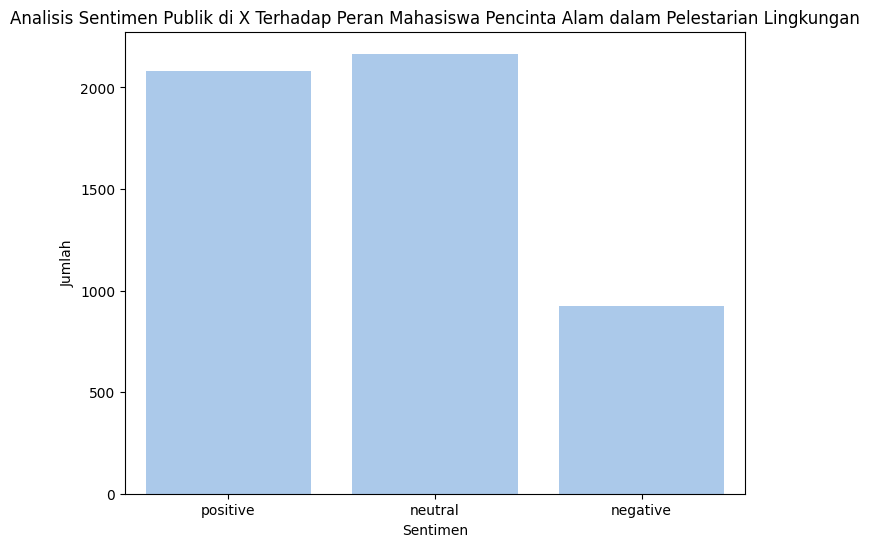

In [33]:
# Visualisasi
print("\nVisualisasi")
sns.set_palette("pastel")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df)
plt.title('Analisis Sentimen Publik di X Terhadap Peran Mahasiswa Pencinta Alam dalam Pelestarian Lingkungan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [34]:
data_positif = df[df['sentimen'] == 'positive']
data_negatif = df[df['sentimen'] == 'negative']
data_netral = df[df['sentimen'] == 'neutral']

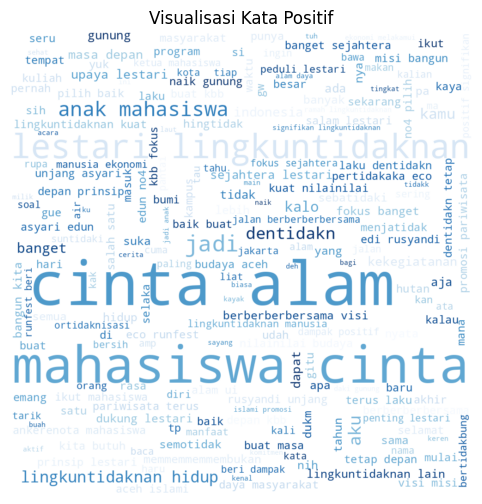

In [35]:
# Word Cloud Positif
if not data_positif.empty:
    all_text_s1 = ' '.join(word for word in data_positif["full_text"].dropna())
    if all_text_s1:
        wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Visualisasi Kata Positif")
        plt.margins(x=0, y=0)
        plt.show()

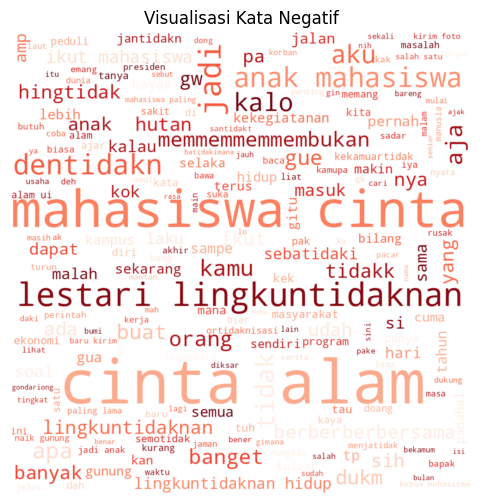

In [36]:
# Word Cloud Negatif
if not data_negatif.empty:
    all_text_s0 = ' '.join(word for word in data_negatif["full_text"].dropna())
    if all_text_s0:
        wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Negatif")
        plt.margins(x=0, y=0)
        plt.show()

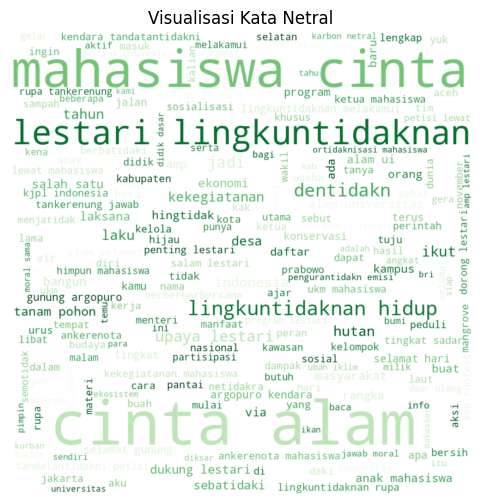

In [37]:
# Word Cloud Netral
if not data_netral.empty:
    all_text_s2 = ' '.join(word for word in data_netral["full_text"].dropna())
    if all_text_s2:
        wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s2)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Netral")
        plt.margins(x=0, y=0)
        plt.show()

In [38]:
# Pembagian Data untuk Pelatihan
print("\nPembagian Data untuk Pelatihan")
x = df.full_text
y = df.sentimen


Pembagian Data untuk Pelatihan


In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [40]:
print('\nBanyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))


Banyak data x_train : 4136
Banyak data x_test  : 1034
Banyak data y_train : 4136
Banyak data y_test  : 1034


In [41]:
print("\nMENAMPILKAN DATA TEST DAN TRAIN")
print("\ndata pertama dari x_train (teks yang sudah diproses):")
print(x_train.head().to_string())
print("\ndata pertama dari x_test (teks yang sudah diproses):")
print(x_test.head().to_string())
print("\ndata pertama dari y_train (label sentimen):")
print(y_train.head())
print("\ndata pertama dari y_test (label sentimen):")
print(y_test.head())


MENAMPILKAN DATA TEST DAN TRAIN

data pertama dari x_train (teks yang sudah diproses):
486     hari kepala balai tnbkds mentidaknanti mahasis...
519     hipotermia mahasiswa cinta alam tewas gunung d...
3874                                      hari seninjumat
5167    lestari lingkuntidaknan rupa tankerenung jawab...
2594    kbb elas edi rusyandi unjang asyari edun no4 p...

data pertama dari x_test (teks yang sudah diproses):
246     cetidakh banjir mahasiswa cinta alam laku hija...
443     semotidak mampu jadi pimpin amanah mampu jadi ...
2660    program edi rusyandi amp unjang asyari edun to...
1138            anak mahasiswa cinta alam gitu kata hyung
2036                 operator sekolah tanya uas jawab via

data pertama dari y_train (label sentimen):
486      neutral
519      neutral
3874    negative
5167     neutral
2594    positive
Name: sentimen, dtype: object

data pertama dari y_test (label sentimen):
246      neutral
443     positive
2660    positive
1138    positive
2036  

In [42]:
print(f"\nUkuran x_train: {x_train.shape}")
print(f"Ukuran x_test: {x_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")


Ukuran x_train: (4136,)
Ukuran x_test: (1034,)
Ukuran y_train: (4136,)
Ukuran y_test: (1034,)


In [43]:
# Pelatihan dan Evaluasi Model Naive Bayes dengan Hyperparameter Tuning
print("pelatihan dan Evaluasi Model Naive Bayes")
# Definisi Pipeline untuk Naive Bayes
pipeline_nb = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

pelatihan dan Evaluasi Model Naive Bayes


In [44]:
# Parameter Grid untuk GridSearchCV
# Eksperimen dengan ngram_range dan max_features untuk TfidfVectorizer
# Eksperimen dengan alpha untuk MultinomialNB
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], # Coba unigram, bigram, trigram
    'vectorizer__max_features': [5000, 10000, 15000], # Jumlah fitur TF-IDF
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0] # Smoothing parameter untuk Naive Bayes
}

In [45]:
# Inisialisasi GridSearchCV
# cv=5 berarti 5-fold cross-validation
# n_jobs=-1 berarti menggunakan semua core CPU yang tersedia
grid_search_nb = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print("\nMemulai GridSearchCV untuk Naive Bayes (ini mungkin memakan waktu)...")
grid_search_nb.fit(x_train, y_train)
print("\nGridSearchCV selesai.")
print(f"Best parameters found: {grid_search_nb.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_nb.best_score_:.4f}")


Memulai GridSearchCV untuk Naive Bayes (ini mungkin memakan waktu)...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

GridSearchCV selesai.
Best parameters found: {'classifier__alpha': 0.1, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.6651


In [46]:
print("\ndata pertama dari x_train (teks yang sudah diproses):")
print(x_train.head().to_string())


data pertama dari x_train (teks yang sudah diproses):
486     hari kepala balai tnbkds mentidaknanti mahasis...
519     hipotermia mahasiswa cinta alam tewas gunung d...
3874                                      hari seninjumat
5167    lestari lingkuntidaknan rupa tankerenung jawab...
2594    kbb elas edi rusyandi unjang asyari edun no4 p...


In [47]:
print("\ndata pertama dari x_test (teks yang sudah diproses):")
print(x_test.head().to_string())


data pertama dari x_test (teks yang sudah diproses):
246     cetidakh banjir mahasiswa cinta alam laku hija...
443     semotidak mampu jadi pimpin amanah mampu jadi ...
2660    program edi rusyandi amp unjang asyari edun to...
1138            anak mahasiswa cinta alam gitu kata hyung
2036                 operator sekolah tanya uas jawab via


In [48]:
print("\ndata pertama dari y_train (label sentimen):")
print(y_train.head())


data pertama dari y_train (label sentimen):
486      neutral
519      neutral
3874    negative
5167     neutral
2594    positive
Name: sentimen, dtype: object


In [49]:
print("\ndata pertama dari y_test (label sentimen):")
print(y_test.head())


data pertama dari y_test (label sentimen):
246      neutral
443     positive
2660    positive
1138    positive
2036     neutral
Name: sentimen, dtype: object


In [50]:
print(f"\nUkuran x_train: {x_train.shape}")
print(f"Ukuran x_test: {x_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")


Ukuran x_train: (4136,)
Ukuran x_test: (1034,)
Ukuran y_train: (4136,)
Ukuran y_test: (1034,)


In [51]:
# Pelatihan Model Naive Bayes dengan TF-IDF
print("\nPelatihan Model Naive Bayes dengan TF-IDF")


Pelatihan Model Naive Bayes dengan TF-IDF


In [52]:
tfidf_vectorizer = TfidfVectorizer(max_features=5170)
naive_bayes_classifier = MultinomialNB()
model_naive_bayes = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])

In [53]:
# Latih model Naive Bayes
model_naive_bayes.fit(x_train, y_train)
print("Model Naive Bayes berhasil dilatih.")

Model Naive Bayes berhasil dilatih.


In [54]:
print("\nMENAMPILKAN REPRESENTASI TF-IDF DAN PROBABILITAS")
trained_tfidf_vectorizer = model_naive_bayes.named_steps['vectorizer']
X_train_tfidf_transformed = trained_tfidf_vectorizer.transform(x_train)
X_test_tfidf_transformed = trained_tfidf_vectorizer.transform(x_test)
print(f"\nShape TF-IDF dari x_train: {X_train_tfidf_transformed.shape}")
print(f"Shape TF-IDF dari x_test: {X_test_tfidf_transformed.shape}")



MENAMPILKAN REPRESENTASI TF-IDF DAN PROBABILITAS

Shape TF-IDF dari x_train: (4136, 5170)
Shape TF-IDF dari x_test: (1034, 5170)


In [55]:
print("\nbaris pertama dari matriks TF-IDF x_train (sparse format):")
print(X_train_tfidf_transformed[:10])


baris pertama dari matriks TF-IDF x_train (sparse format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 112 stored elements and shape (10, 5170)>
  Coords	Values
  (0, 237)	0.12966553545557963
  (0, 458)	0.29546487991836856
  (0, 489)	0.2399770032259703
  (0, 698)	0.3293788598907881
  (0, 712)	0.29546487991836856
  (0, 842)	0.13505766018559912
  (0, 1154)	0.23857243657600694
  (0, 1217)	0.290120146753236
  (0, 1441)	0.163971387191439
  (0, 2306)	0.25994964473180404
  (0, 2747)	0.1969684309429546
  (0, 2749)	0.20880995075098752
  (0, 2898)	0.0682664792948055
  (0, 3389)	0.25766181964354357
  (0, 4538)	0.28540575798974266
  (0, 4809)	0.19600390132492496
  (0, 4851)	0.290120146753236
  (0, 4916)	0.17671782969320668
  (1, 237)	0.11691910345377932
  (1, 842)	0.12178116943707838
  (1, 970)	0.5732345718452444
  (1, 1392)	0.2880228421727977
  (1, 1506)	0.5940002616694054
  (1, 2898)	0.12311144248240084
  (1, 4656)	0.43812269960912226
  :	:
  (6, 5022)	0.20127425616994143
  (6

In [56]:
print("\nJumlah fitur (kata unik) yang dipelajari oleh TF-IDF Vectorizer:", len(trained_tfidf_vectorizer.get_feature_names_out()))
print("\nBeberapa fitur (kata) pertama yang dipelajari oleh TF-IDF Vectorizer:")
print(trained_tfidf_vectorizer.get_feature_names_out()[:20])


Jumlah fitur (kata unik) yang dipelajari oleh TF-IDF Vectorizer: 5170

Beberapa fitur (kata) pertama yang dipelajari oleh TF-IDF Vectorizer:
['0038' '01' '01binamu' '02' '0300' '0303' '03032020' '0313kpr' '03l'
 '03patuk' '0409' '0424' '05' '0503' '05tuntang' '06' '0731kulon'
 '081238567544' '0823' '0857']


In [57]:
# Untuk melihat TF-IDF dari sebuah teks
if not x_train.empty:
    sample_text_train = x_train.iloc[0]
    sample_tfidf_train = trained_tfidf_vectorizer.transform([sample_text_train])
    print(f"\nTF-IDF untuk contoh teks pertama dari x_train ('{sample_text_train[:50]}...'):")

    print(sample_tfidf_train.toarray())

    feature_names = trained_tfidf_vectorizer.get_feature_names_out()
    print("Fitur dengan bobot non-nol untuk contoh teks ini:")

    non_zero_cols = sample_tfidf_train.nonzero()[1]
    for col_idx in non_zero_cols:
        print(f"  {feature_names[col_idx]}: {sample_tfidf_train[0, col_idx]:.4f}")



TF-IDF untuk contoh teks pertama dari x_train ('hari kepala balai tnbkds mentidaknanti mahasiswa c...'):
[[0. 0. 0. ... 0. 0. 0.]]
Fitur dengan bobot non-nol untuk contoh teks ini:
  alam: 0.1297
  balai: 0.2955
  bapak: 0.2400
  borneo: 0.3294
  brawijaya: 0.2955
  cinta: 0.1351
  ekspedisi: 0.2386
  expedition: 0.2901
  hari: 0.1640
  kepala: 0.2599
  laksana: 0.1970
  lama: 0.2088
  mahasiswa: 0.0683
  of: 0.2577
  tanjung: 0.2854
  tuju: 0.1960
  ub: 0.2901
  universitas: 0.1767


In [58]:
print("\n--- Probabilitas Prediksi")
y_proba_nb = model_naive_bayes.predict_proba(x_test)
print("\nProbabilitas prediksi untuk 10 sampel pertama dari x_test:")
proba_df = pd.DataFrame(y_proba_nb[:5], columns=model_naive_bayes.classes_)
print(proba_df)


--- Probabilitas Prediksi

Probabilitas prediksi untuk 10 sampel pertama dari x_test:
   negative   neutral  positive
0  0.022133  0.909144  0.068723
1  0.096591  0.160687  0.742722
2  0.002336  0.036843  0.960821
3  0.248082  0.082494  0.669424
4  0.052495  0.822441  0.125064


In [59]:
print("\nContoh probabilitas untuk satu teks dari x_test:")
if not x_test.empty:
    sample_text_test = x_test.iloc[0]
    sample_proba = model_naive_bayes.predict_proba([sample_text_test])
    print(f"Teks: '{sample_text_test[:50]}...'")
    print(f"Probabilitas: {sample_proba[0]}")
    # Menampilkan probabilitas dengan label kelas
    for i, class_label in enumerate(model_naive_bayes.classes_):
        print(f"  {class_label}: {sample_proba[0][i]:.4f}")
    print(f"Prediksi kelas: {model_naive_bayes.predict([sample_text_test])[0]}")


Contoh probabilitas untuk satu teks dari x_test:
Teks: 'cetidakh banjir mahasiswa cinta alam laku hijau si...'
Probabilitas: [0.02213325 0.90914353 0.06872321]
  negative: 0.0221
  neutral: 0.9091
  positive: 0.0687
Prediksi kelas: neutral


In [60]:
# MENAMPILKAN TF-IDF DAN PROBABILITAS
#print("\nEvaluasi Model Naive Bayes")
y_pred_nb = model_naive_bayes.predict(x_test)

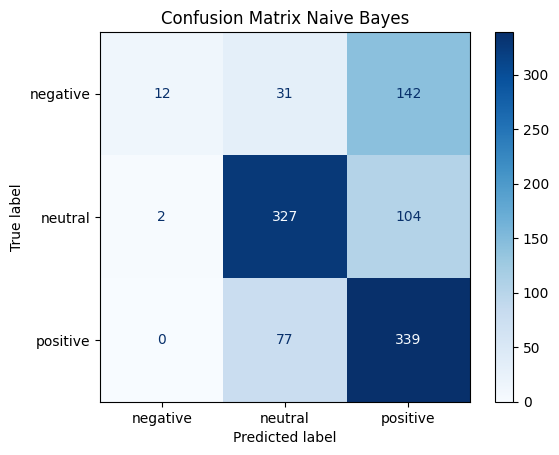

In [61]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=model_naive_bayes.classes_)
disp_nb.plot(cmap='Blues')
plt.title('Confusion Matrix Naive Bayes')
plt.show()

In [62]:
# Classification Report
matrix_nb = classification_report(y_test, y_pred_nb)
print('Classification Report (Naive Bayes):\n', matrix_nb)

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

    negative       0.86      0.06      0.12       185
     neutral       0.75      0.76      0.75       433
    positive       0.58      0.81      0.68       416

    accuracy                           0.66      1034
   macro avg       0.73      0.54      0.52      1034
weighted avg       0.70      0.66      0.61      1034



In [63]:
# Informasi Internal Model Naive Bayes
print("\nINFORMASI INTERNAL MODEL NAIVE BAYES")
trained_vectorizer = model_naive_bayes.named_steps['vectorizer']
trained_classifier = model_naive_bayes.named_steps['classifier']


INFORMASI INTERNAL MODEL NAIVE BAYES


In [64]:
vocabulary = trained_vectorizer.vocabulary_
print("\nUkuran Vocabulary:", len(vocabulary))


Ukuran Vocabulary: 5170


In [65]:
X_train_tfidf_transformed_for_info = trained_vectorizer.transform(x_train) # Re-transform for info if needed
print(f"\nShape Matriks TF-IDF (x_train): {X_train_tfidf_transformed_for_info.shape}")


Shape Matriks TF-IDF (x_train): (4136, 5170)


In [66]:
class_labels = trained_classifier.classes_
print("\nNama Kelas (Sentimen):", class_labels)



Nama Kelas (Sentimen): ['negative' 'neutral' 'positive']


In [67]:
log_prior_classes = trained_classifier.class_log_prior_
print("\nLog Probabilitas Prior Kelas:")
for i, label in enumerate(class_labels):
    print(f"  Log P({label}): {log_prior_classes[i]:.4f}")


Log Probabilitas Prior Kelas:
  Log P(negative): -1.7249
  Log P(neutral): -0.8699
  Log P(positive): -0.9093


In [68]:
log_likelihood_features = trained_classifier.feature_log_prob_
print(f"\nShape Log Probabilitas Likelihood Fitur: {log_likelihood_features.shape}")


Shape Log Probabilitas Likelihood Fitur: (3, 5170)


In [69]:
print("\n10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:")
feature_names = trained_vectorizer.get_feature_names_out()
for i, class_label in enumerate(class_labels):
    top_10_indices = log_likelihood_features[i, :].argsort()[-10:][::-1]
    top_10_words = [feature_names[idx] for idx in top_10_indices]
    top_10_probs = [f"{log_likelihood_features[i, idx]:.4f}" for idx in top_10_indices]
    print(f"  Kelas '{class_label}':")
    for j in range(10):
        print(f"    - {top_10_words[j]} (Log Prob: {top_10_probs[j]})")


10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:
  Kelas 'negative':
    - mahasiswa (Log Prob: -5.0856)
    - cinta (Log Prob: -5.0957)
    - alam (Log Prob: -5.1376)
    - anak (Log Prob: -5.6326)
    - jadi (Log Prob: -5.9663)
    - lingkuntidaknan (Log Prob: -6.1019)
    - lestari (Log Prob: -6.1818)
    - dentidakn (Log Prob: -6.2392)
    - aku (Log Prob: -6.2448)
    - apa (Log Prob: -6.2609)
  Kelas 'neutral':
    - lingkuntidaknan (Log Prob: -4.8985)
    - lestari (Log Prob: -4.9512)
    - alam (Log Prob: -4.9850)
    - mahasiswa (Log Prob: -5.0010)
    - cinta (Log Prob: -5.0187)
    - hidup (Log Prob: -6.0258)
    - dentidakn (Log Prob: -6.0423)
    - selamat (Log Prob: -6.0625)
    - indonesia (Log Prob: -6.1142)
    - hari (Log Prob: -6.1626)
  Kelas 'positive':
    - alam (Log Prob: -4.4316)
    - cinta (Log Prob: -4.4326)
    - mahasiswa (Log Prob: -4.4513)
    - lingkuntidaknan (Log Prob: -5.0308)
    - lestari (Log Prob: -5.0790)
    - anak (Log Prob: -5.3294)


In [70]:
# Pengujian Model Naïve Bayes
print("\nPengujian Model Naive Bayes")
def classify_text_with_naive_bayes(input_text):

    processed_text = input_text.lower()
    processed_text = clean_twitter_text(processed_text)
    processed_text = normalisasi(processed_text)
    processed_text = stopword(processed_text) # Corrected function name
    processed_text = stemming_text(processed_text) # Pastikan ini mengembalikan string
    # Prediksi menggunakan pipeline Naive Bayes
    prediction = model_naive_bayes.predict([processed_text])
    # Probabilitas prediksi
    prediction_proba = model_naive_bayes.predict_proba([processed_text])
    return prediction[0], prediction_proba[0]

input_text_user = input("\nMasukkan teks yang ingin diklasifikasikan oleh Naive Bayes: ")
results_nb_class, results_nb_proba = classify_text_with_naive_bayes(input_text_user)
print("Input teks :", input_text_user)
print(f"Hasil Klasifikasi (Multinomial Naive Bayes): {results_nb_class}")
print("Probabilitas untuk setiap kelas:")
for i, class_label in enumerate(model_naive_bayes.classes_):
    print(f"  {class_label}: {results_nb_proba[i]:.4f}")


Pengujian Model Naive Bayes

Masukkan teks yang ingin diklasifikasikan oleh Naive Bayes: pelestarian
Input teks : pelestarian
Hasil Klasifikasi (Multinomial Naive Bayes): neutral
Probabilitas untuk setiap kelas:
  negative: 0.1782
  neutral: 0.4190
  positive: 0.4028
